## Ecommerce Trade Sales

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pytrends.request import TrendReq
from statsmodels.tsa.stattools import kpss, adfuller
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy.stats import pearsonr
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale 

### Reading and Filtering data

In [3]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [4]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [5]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


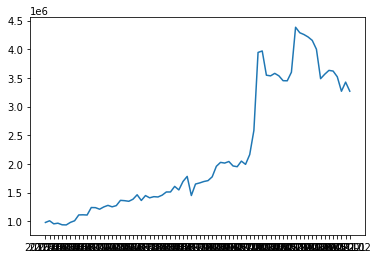### Time series plot of Ecommerce trade sales

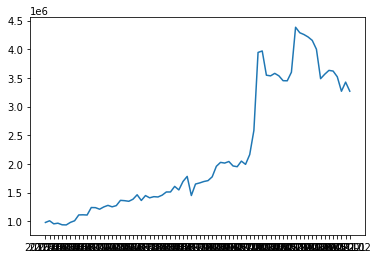

In [6]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index = retailEcommercesales_dup['Date']
plt.plot(retailEcommercesales_dup['Ecommerce_sales'])
plt.show()

In [7]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')

In [8]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales
Date,
2016-01,977198
2016-02,1006610


**Growth Rate of Ecommerce Retail Sales**

In [9]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts[['Growth_rate']].index)
#plt.plot(retailEcommercesales_ts['Growth_rate'])
#plt.show()

In [10]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-02-01,1006610,0.030098
2016-03-01,953186,-0.053073


**Time series for growth rate**

In [11]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

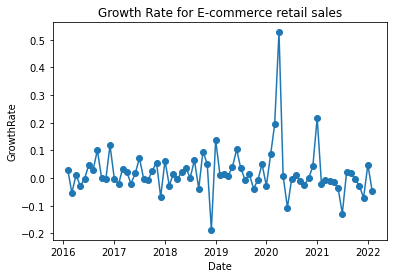

<Figure size 1600x500 with 0 Axes>

In [14]:
# Plot

plt.plot(retailEcommercesales_ts['Growth_rate'], marker = 'o')

# Labelling
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for E-commerce retail sales")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

### Stationarity Statistical test

**KPSS and ADF Test**

In [12]:
def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"
        
def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

**Testing the ecommerce sale\'s series stationarity**

In [14]:
kpss_test(retailEcommercesales_ts['Growth_rate'])
adf_test(retailEcommercesales_ts['Growth_rate'])

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


'Series is stationary'

### Keywords extraction using PyTrend

In [16]:
pytrends = TrendReq(hl = 'en-us', backoff_factor = 0.1)

def ecommerce_trend(keywords = [''],category = '340'):  #subcat - 280
    
    """ 
    Function for getting trends for selected keywords
        
        arguments: 
        
            Keywords: List of String ser
            category: String: stores the code for category
        
        returns: Related queries and related topics from google trend as a data frame
    """
    kw_list = keywords
    cat = category
    timeframe = '2004-01-01 2022-05-11'
    geo = 'CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop = '')
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    
    return data, queries, topics

In [17]:
data2, queries2, topics2 = ecommerce_trend(keywords = ['Doordash'],category = '340')

In [18]:
data2.tail()

,Doordash,isPartial
date,,
2022-01-01,100,False
2022-02-01,95,False
2022-03-01,58,False
2022-04-01,87,False
2022-05-01,65,True


### Normalizing time series

In [13]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic

keywords_csv = pd.read_csv('../../data/keywords_data/ECOMMERCE.csv')

In [20]:
for index, row in keywords_csv.iterrows():
    #print(([row['Keyword']]))
    data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
    
    if index==0:
        FinalData, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        FinalData.rename(columns = {'':str(row['Keyword'])}, inplace = True)    #column name for frame
        FinalData=FinalData.drop(columns=['isPartial'])   #remove column
    else:
        data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        data.rename(columns = {'':str(row['Keyword'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['Keyword'])]
        FinalData = FinalData.join(data)

In [21]:
FinalData

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,59,0,...,0,0,53,36,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,49,46,47,0,0,0,0,0
2004-03-01,0,0,0,0,0,0,0,0,29,0,...,0,0,41,22,57,0,100,0,0,100
2004-04-01,0,0,0,0,0,0,0,0,24,0,...,0,0,44,48,23,0,0,0,0,40
2004-05-01,0,0,0,0,0,0,0,0,63,0,...,0,0,48,40,20,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-01,82,100,77,58,45,0,19,0,28,25,...,0,20,53,70,29,82,42,87,55,60
2022-02-01,86,95,21,83,38,33,27,0,20,16,...,37,34,51,69,32,75,14,75,54,46
2022-03-01,83,58,57,83,100,0,19,32,22,8,...,32,30,49,69,26,82,25,87,62,79


In [22]:
#keywords exported as CSV
FinalData.to_csv('EcommerceKeywordTimeSeries.csv')

**Queries and Topics**

In [23]:
category_ts, queries, topics = ecommerce_trend(keywords = [''],category = '340')  #function calling

keyword_query_frame = dict()  #Dictionary for queries
keyword_topic_frame = dict()  #Dictionary for topic

# keywords from queries
keyword_rising_query = queries['']['rising']['query'].unique().tolist() 
keyword_top_query = queries['']['top']['query'].unique().tolist()

# keywords from topic
keyword_rising_topics = topics['']['rising']['topic_title'].unique().tolist() 
keyword_top_topics = topics['']['top']['topic_title'].unique().tolist()

In [24]:
# keywords dict

keyword_query_frame['340'] = keyword_top_query
keyword_topic_frame['340'] = keyword_top_topics

In [25]:
keyword_topic_frame

{'340': ['PayPal',
  'Payment',
  'Money',
  'Canada',
  'Shopify',
  'Number',
  'Western Union',
  'Bank',
  'MoneyGram International Inc',
  'PayPal CA ltd',
  'Account',
  'Invoice',
  'Moneris',
  'Credit',
  'TD Canada Trust',
  'Credit card',
  'E-commerce',
  'Cheque',
  'Google',
  'Electronic funds transfer',
  'Routing number']}

### Evaluating Category Time Series

In [26]:
category_ts = category_ts.drop(columns = 'isPartial')
category_ts['Growth_rate'] = category_ts.pct_change()
category_ts = category_ts.dropna()

In [27]:
category_ts.head(2)

,,Growth_rate
date,,
2004-02-01,94,0.044444
2004-03-01,80,-0.148936


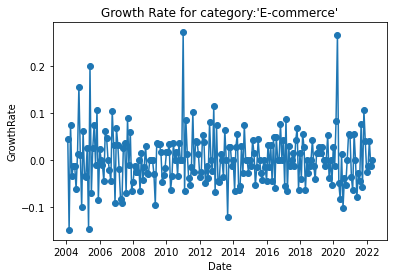

<Figure size 1600x500 with 0 Axes>

In [28]:
# Plot
plt.plot(category_ts['Growth_rate'], marker = 'o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for category:'E-commerce'")
plt.figure(figsize = (16,5), dpi = 100)


# Display
plt.show()

**Category Stationarity Test**

In [29]:
kpss_test(category_ts['Growth_rate'])

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


'Series is stationary'

In [30]:
adf_test(category_ts['Growth_rate'])

'Series is stationary'

### Wrangling Manually extracted Keywords

In [14]:
ecommerce_keyword_ts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts.rename(columns = {'date':'Date'}, inplace = True)
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['Date'])
ecommerce_keyword_ts.index = pd.to_datetime(ecommerce_keyword_ts.index)
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()

In [32]:
ecommerce_keyword_ts.head(2)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,59,0,...,0,0,53,36,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,49,46,47,0,0,0,0,0


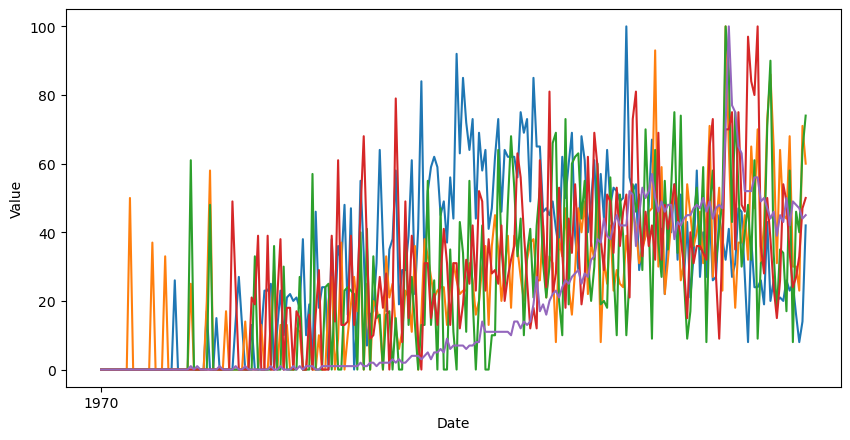

In [40]:
keywordsts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
keywordsts.index = pd.to_datetime(keywordsts.index)
plot_df(keywordsts[keywordsts.columns[10:15]], width = 10)

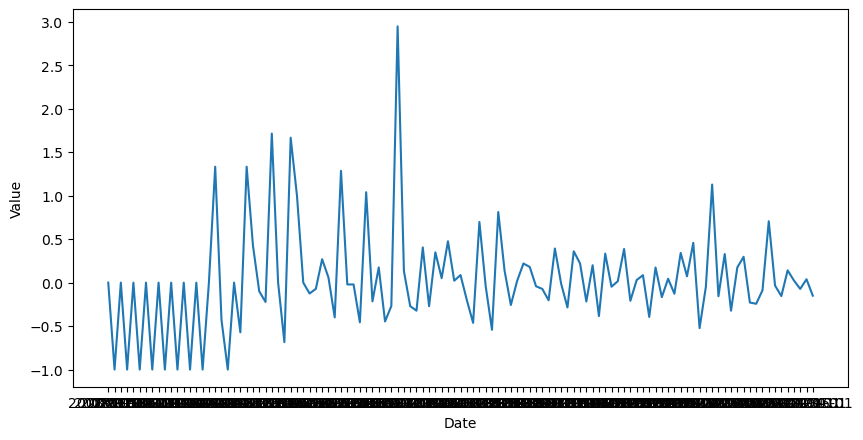

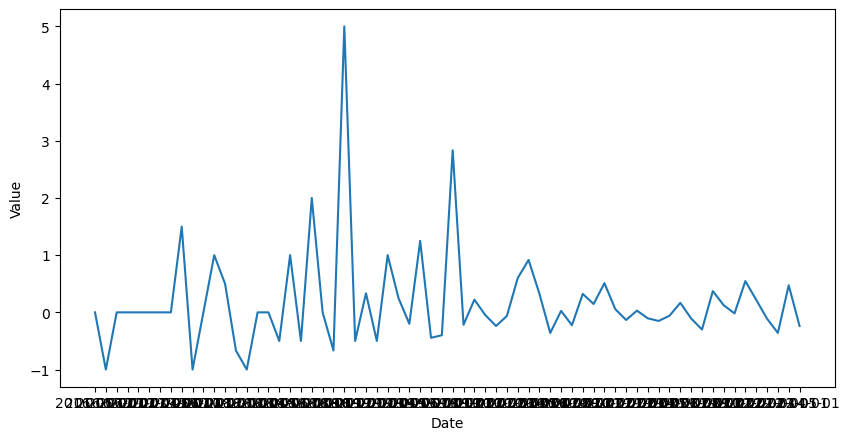

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


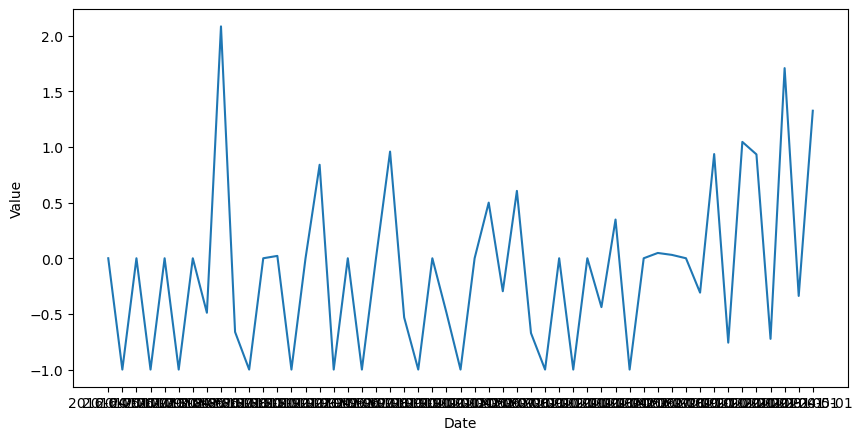

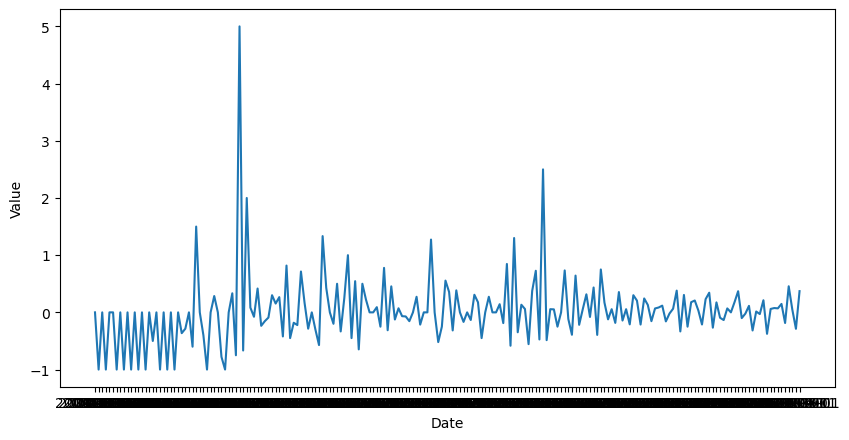

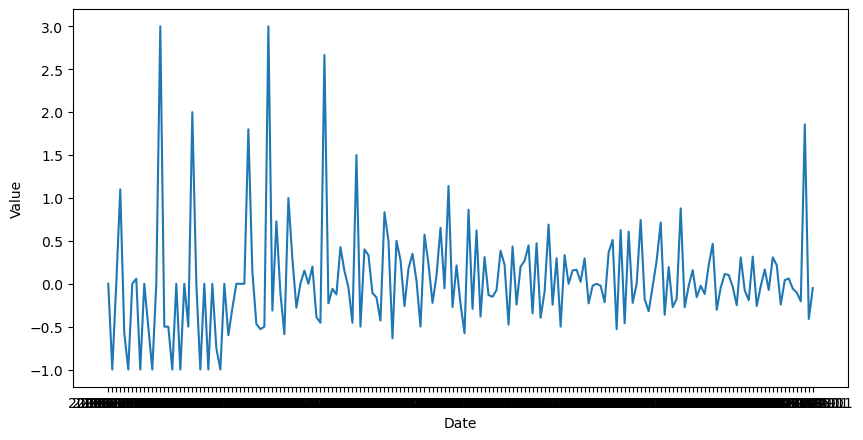

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


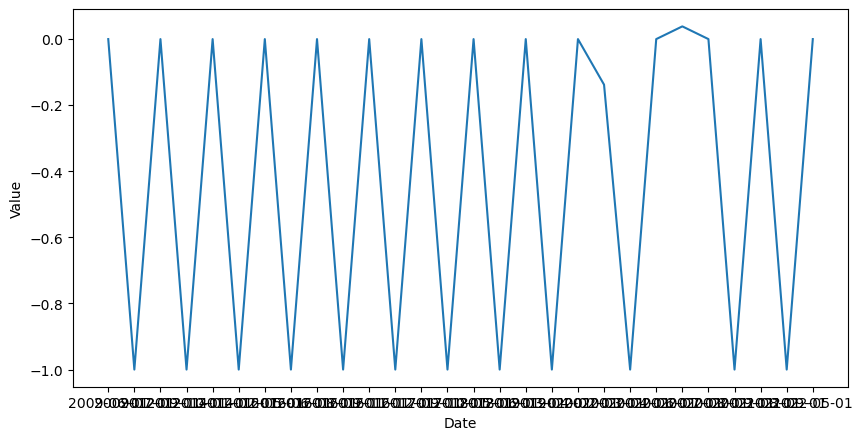

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


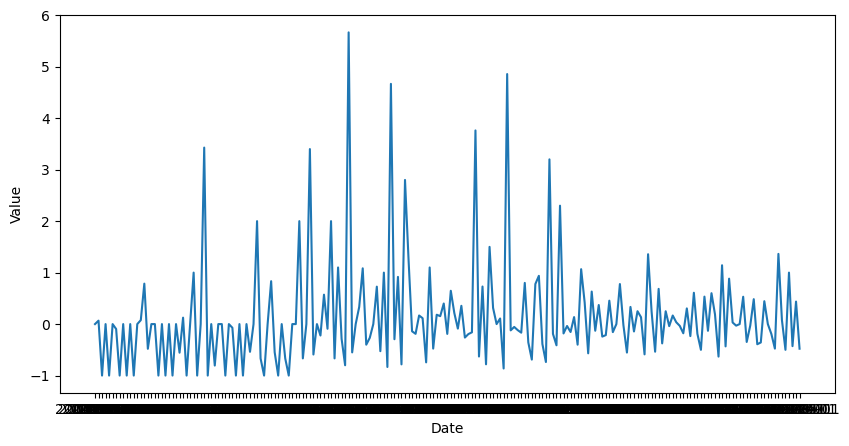

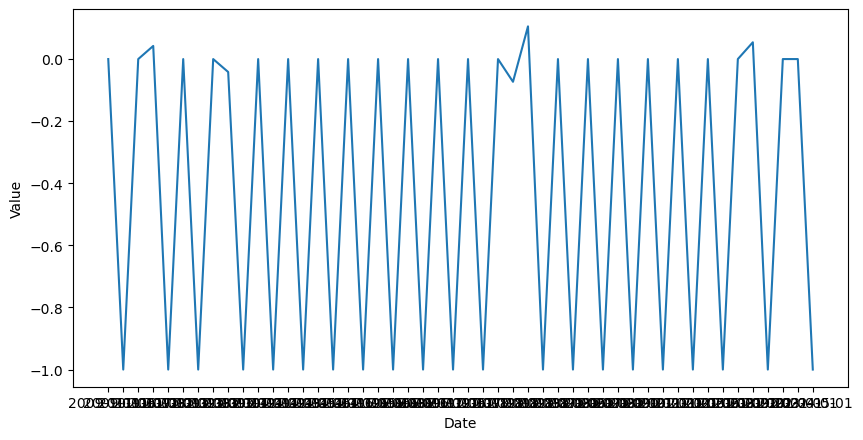

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


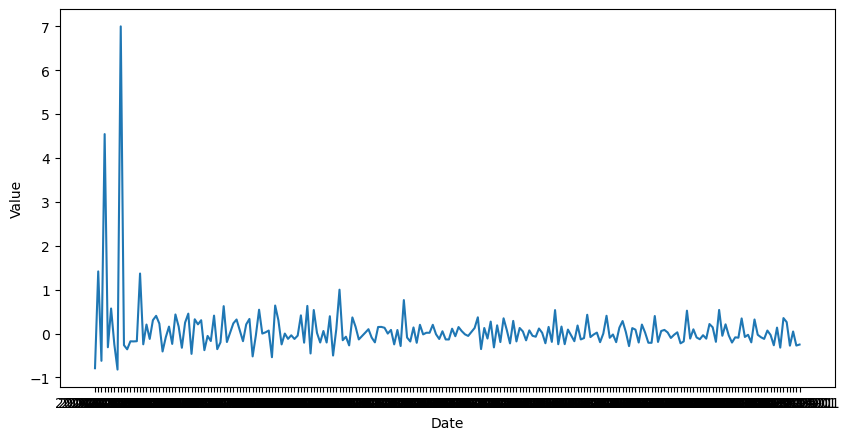

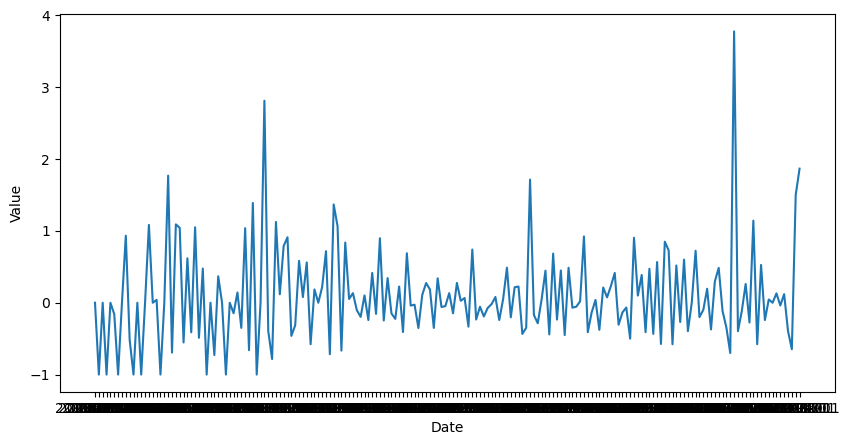

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


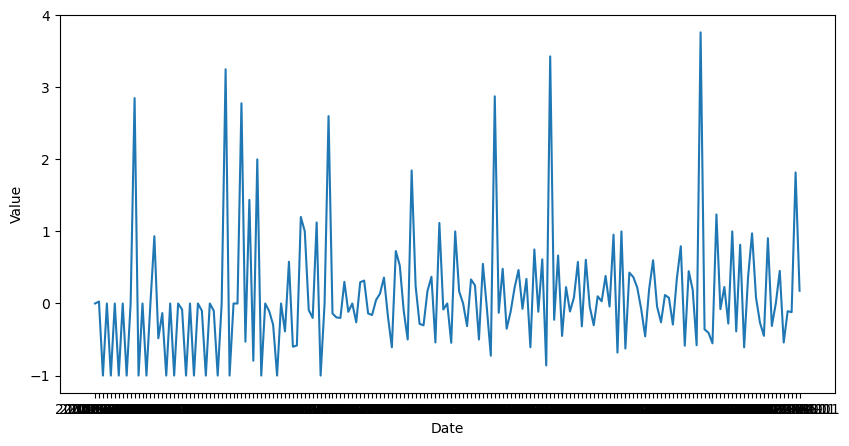

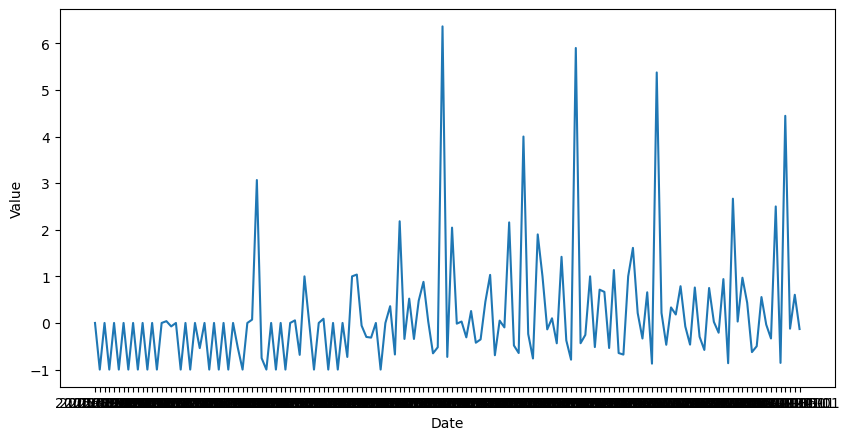

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


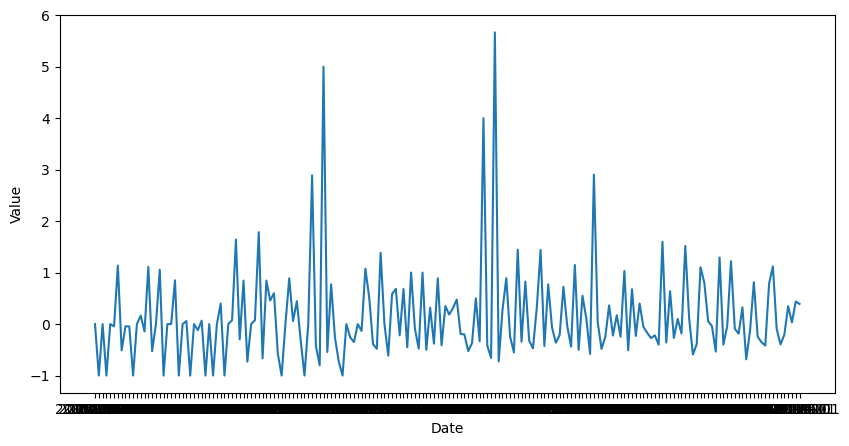

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


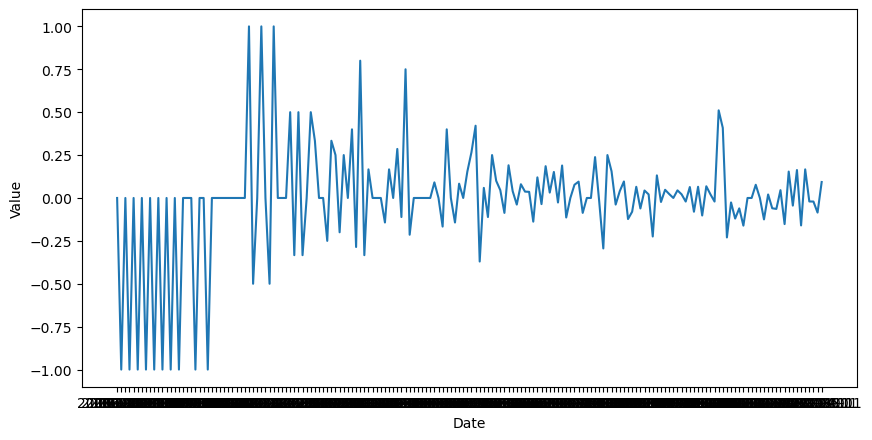

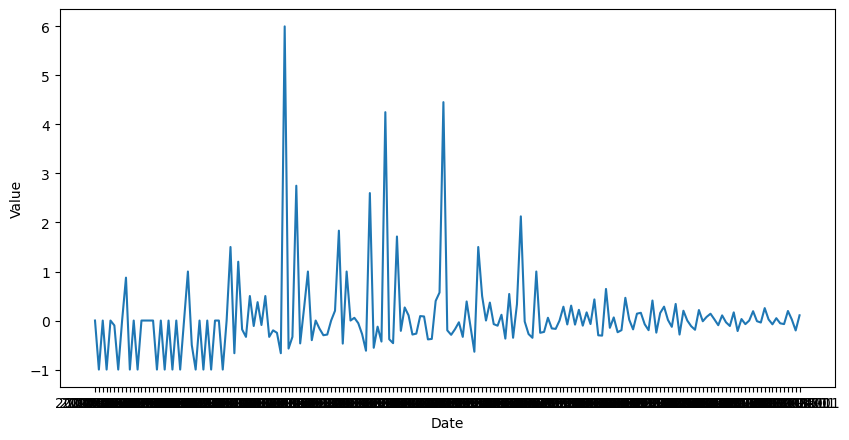

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


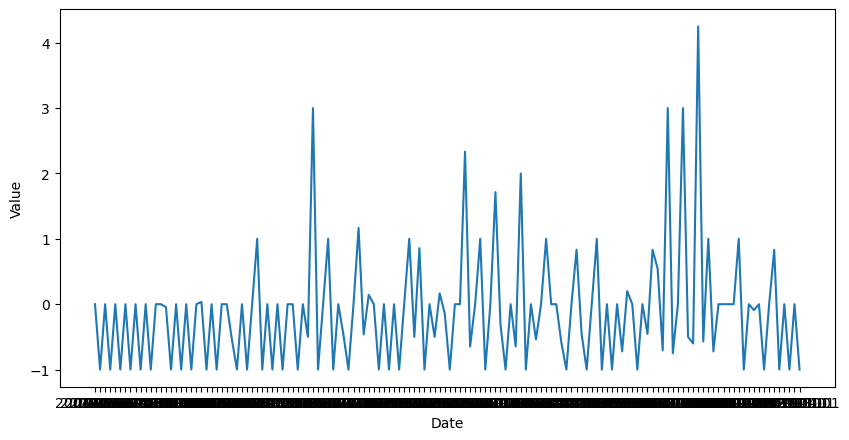

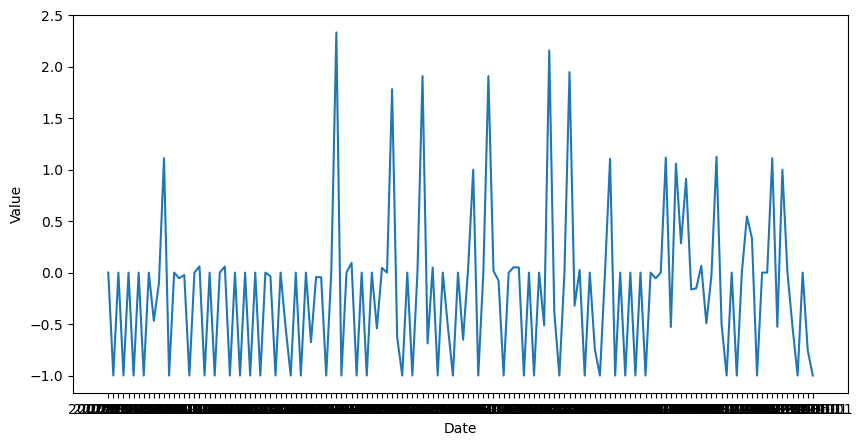

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


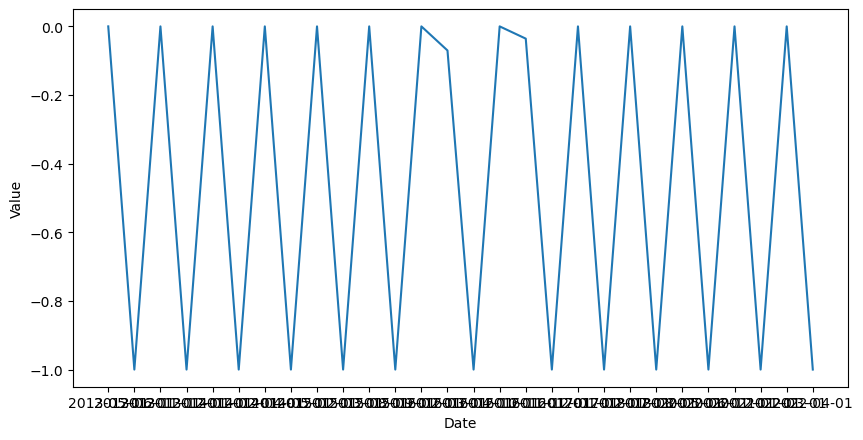

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


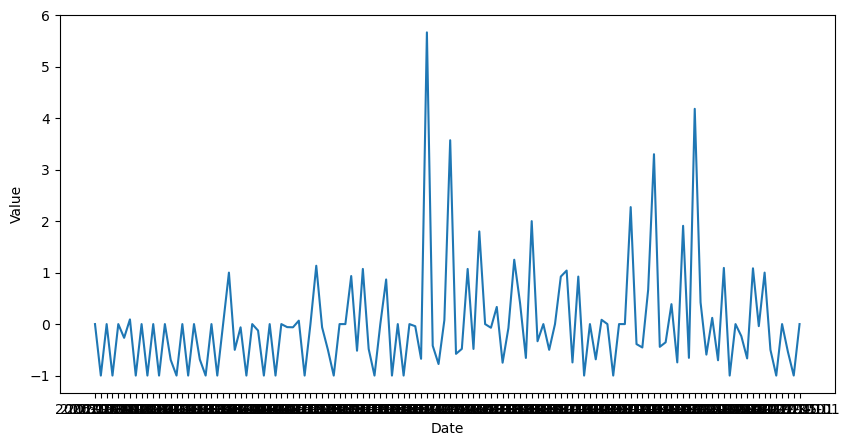

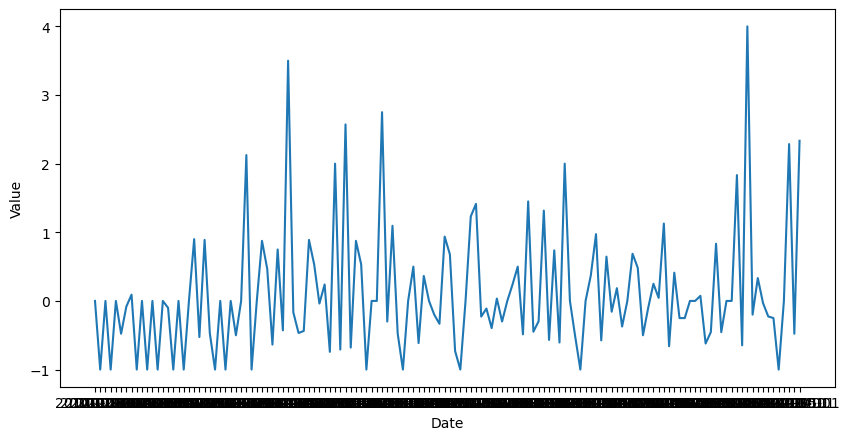

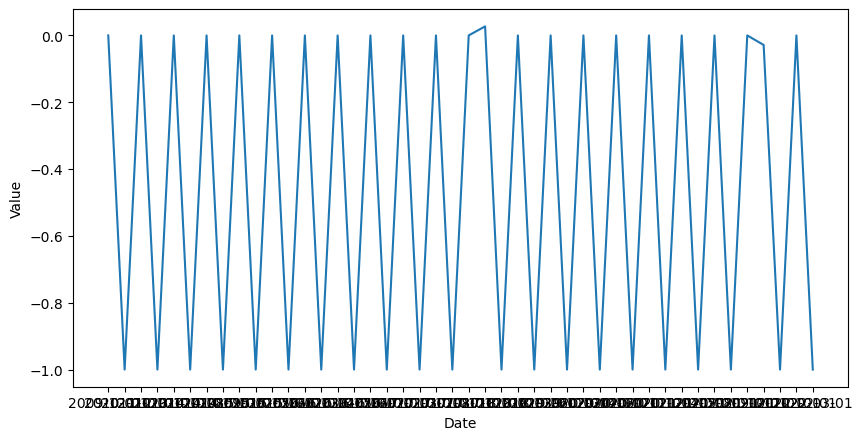

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


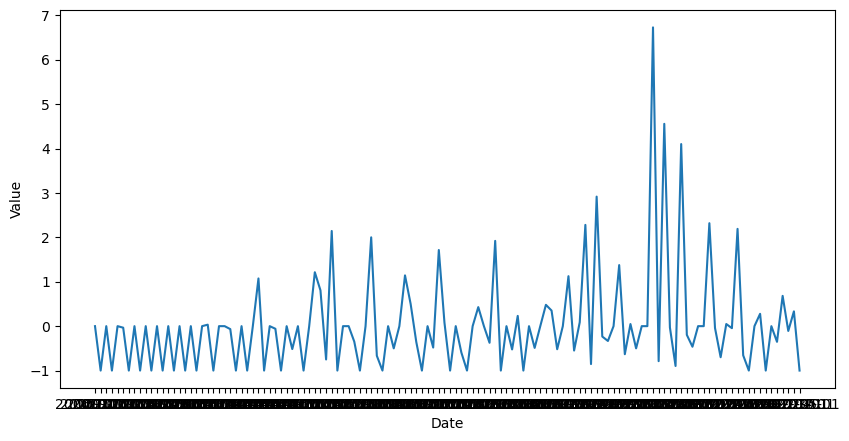

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


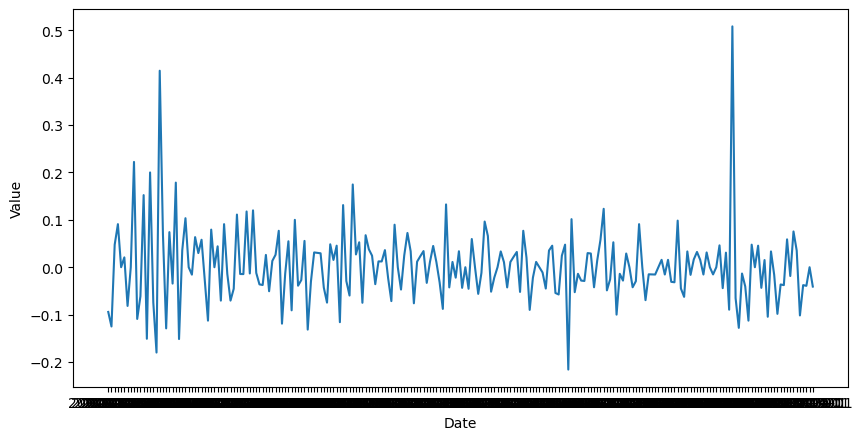

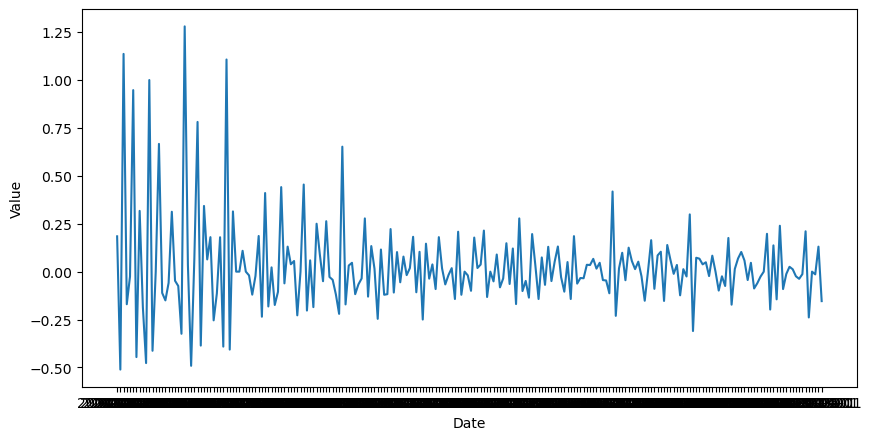

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


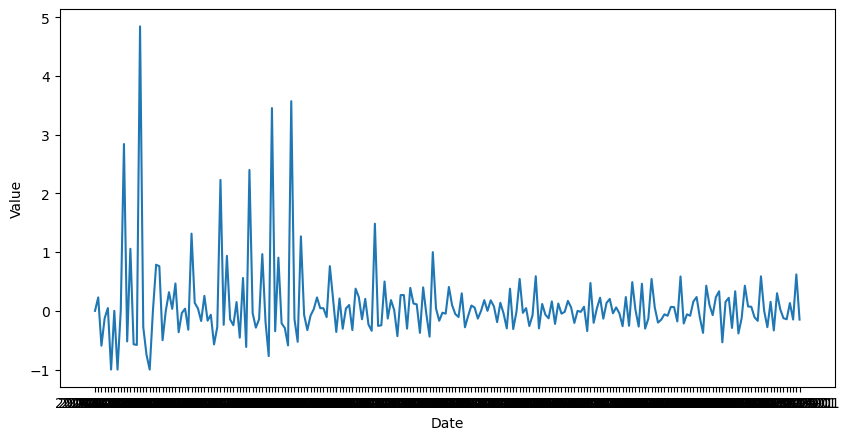

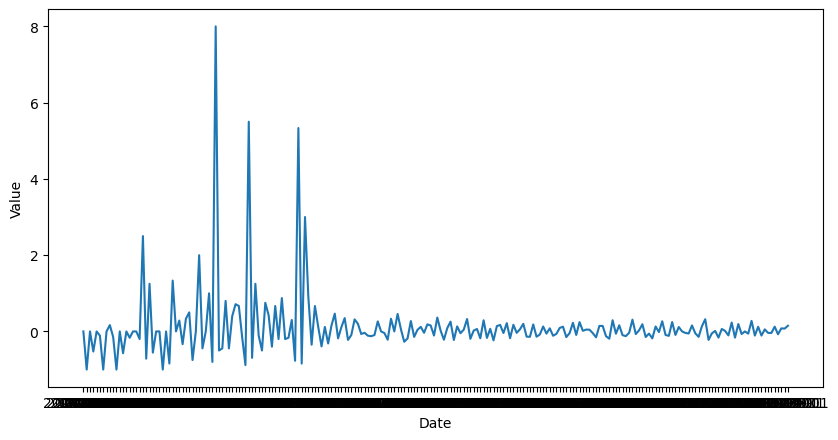

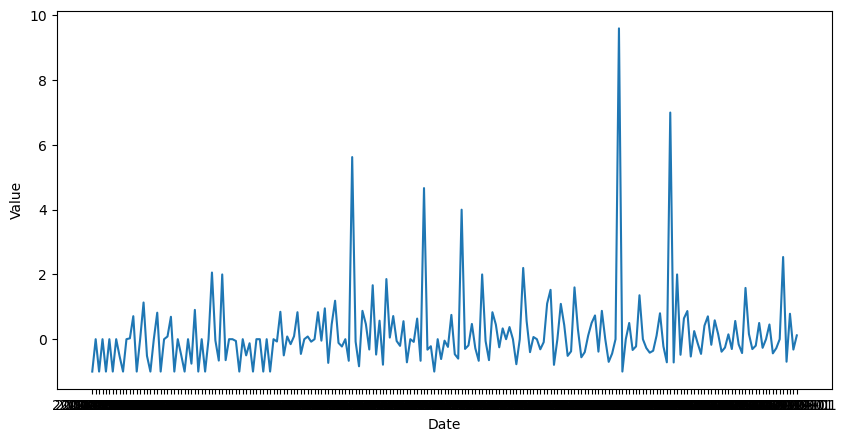

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


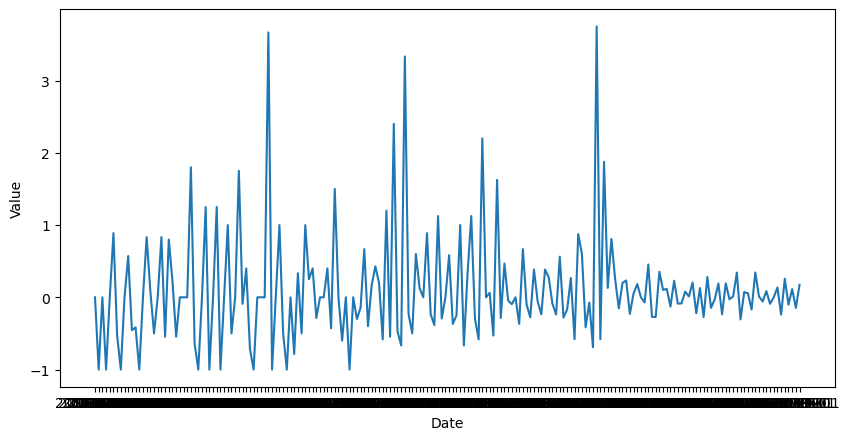

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


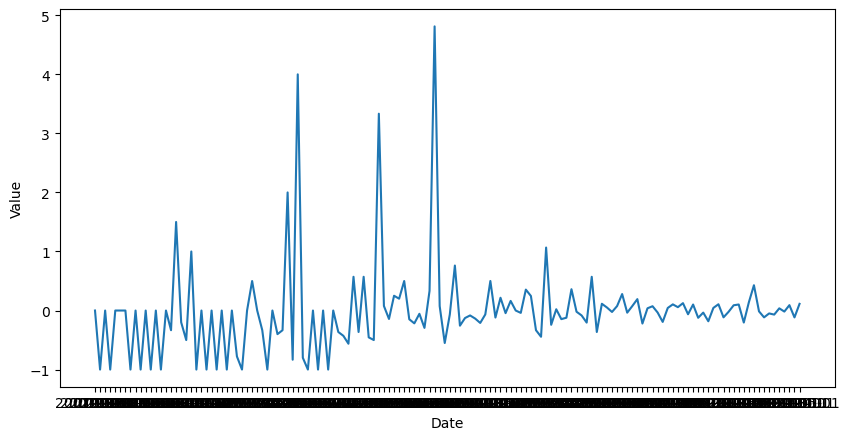

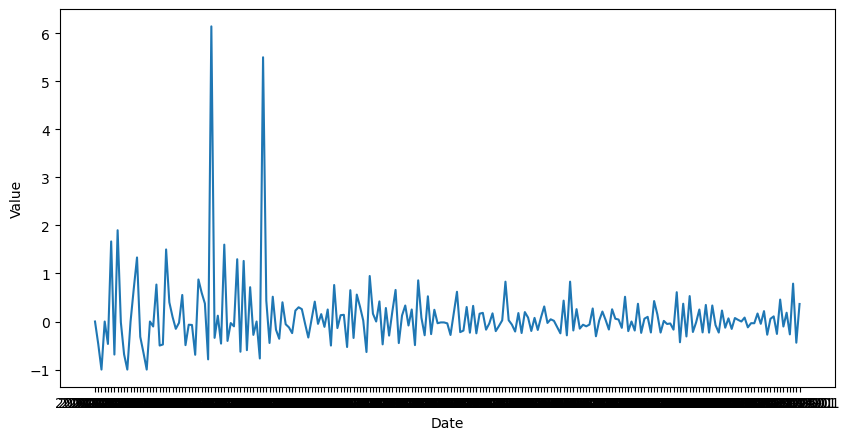

In [18]:
for column in ecommerce_keyword_ts:
    df = pd.DataFrame()
    df['Growth_rate'] = ecommerce_keyword_ts[column].pct_change()
    df = df.dropna()
    df.replace([np.inf, -np.inf], 0, inplace=True)
    plot_df(df,width=10)
    adf_test(df['Growth_rate'])
    kpss_test(df['Growth_rate'])


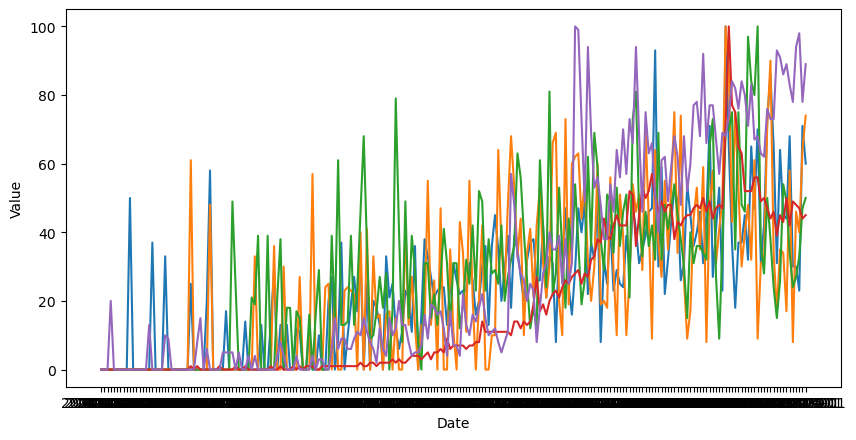

In [34]:
plot_df(ecommerce_keyword_ts[ecommerce_keyword_ts.columns[10:15]], width = 10)

In [35]:
# get dataframe of timeseries for categories

cat_queries_dict = {}
cat_topics_dict = {}

def cat_dict():
    
    # get time series and related queries and topics of categories
    for i, category in enumerate(cat_lst):
        category = str(category)
        data, queries, topics = get_trends(category=category, related_queries=2, related_topics=2)
        cat_queries_dict[category] = queries
        cat_topics_dict[category] = topics

        #Code to append data for different columns in data frame
        if i == 0:
            data.rename(columns = {'': category}, inplace = True)
            categoryts = data.drop(columns=['isPartial'])
        else:
            data.rename(columns = {'': category}, inplace = True)
            data = data.drop(columns=['isPartial'])
            categoryts = categoryts.join(data)

#  Trend removal

### Extracting and removing trend

In [15]:
def get_long_term_trend(dataframe, freq='M'):
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data


In [ ]:
#transformed_data = remove_downward_trend_bias(ecommerce_keyword_ts, ecommerce_keyword_ts)

In [111]:
def make_predictors_df(*arg):
    "joins the predictors dataframes"
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            if i == 0:
                arg[i].index = pd.to_datetime(arg[i].index)
                arg[i+1].index = pd.to_datetime(arg[i+1].index)
                predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
            else:
                predictors_df = pd.merge(predictors_df, arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df

# Normalize data

In [17]:
def normalize(dataframe):
    """ function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df

# difference
def detrend(dataframe):
    return dataframe.diff().dropna()

# seasonality
def remove_seasonality(dataframe):
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data

# cyclicity 
def remove_volatility(dataframe):
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data

In [18]:
#temp = remove_downward_trend_bias(retailsales1, retailsales1, freq = 'M')
normalized_ecommerce_keyword = normalize(ecommerce_keyword_ts)
detrend_ecommerce_keyword = (detrend(normalized_ecommerce_keyword))
#detrend_ecommerce_keyword = detrend(detrend(normalized_ecommerce_keyword))
#ds_ecommerce_keyword = remove_seasonality(detrend_ecommerce_keyword)
#check_stationarity(detrend_ecommerce_keyword)

In [19]:
predictor = make_predictors_df(detrend_ecommerce_keyword)
response = make_predictors_df(retailEcommercesales_ts[['Growth_rate']])

In [42]:
detrend_ecommerce_keyword.head(3)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.094266,0.0,...,0.0,0.0,-0.297607,0.640851,2.354981,0.0,-4.610152,0.0,0.0,0.000000
2004-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.119203,0.0,...,0.0,0.0,-0.595214,-1.538042,0.501060,0.0,5.762690,0.0,0.0,5.862202
2004-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.329177,0.0,...,0.0,0.0,0.223205,1.666212,-1.703603,0.0,-5.762690,0.0,0.0,-3.517321


### Split dataset into train, validation, test dataset

In [20]:
def ts_train_test_split(response, predictor, test_size):
    " splits the train and test set and also returns the extra test data of predictors"
    # train test split
    joind_df = pd.merge(response, predictor, left_index=True, right_index=True)
    train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
    # extra test data
    extra_test_data = predictor.loc[predictor.index > joind_df.index[len(joind_df.index)-1], :]
    return train, test, extra_test_data

In [21]:
train_df, test_df, extra_df = ts_train_test_split(retailEcommercesales_ts[['Growth_rate']],detrend_ecommerce_keyword, 0.3)

In [47]:
extra_df

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-01,-0.094373,-1.825946,1.941314,0.000000,3.010142,-2.712795,-0.540994,2.246181,0.131671,-0.337504,...,-0.327015,-0.194631,-0.148804,0.000000,-0.300636,0.267234,0.633896,0.410775,0.323856,1.934527
2022-04-01,0.000000,1.431147,-1.024582,-0.979539,-1.942027,0.000000,0.338121,0.000000,-0.329177,0.253128,...,-2.092896,0.486577,0.000000,0.640851,1.002119,0.229058,-0.461015,-0.513469,-0.364338,-1.875905
2022-05-01,-0.440409,-1.085698,2.642344,0.340709,-0.436956,3.617060,-0.540994,1.193284,0.000000,1.181264,...,0.000000,-1.946306,-0.148804,-0.640851,-0.400848,0.458116,0.115254,0.342313,0.485785,0.058622


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


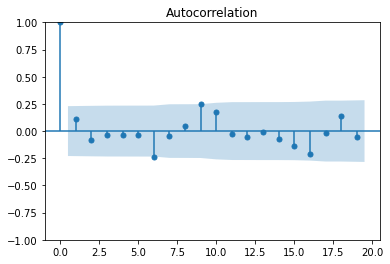

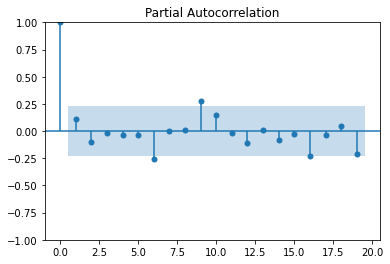

In [22]:
def lag_plots(data):
    """plots acf and pacf plots"""
    plot_acf(data)
    plot_pacf(data)
    
lag_plots(retailEcommercesales_ts[['Growth_rate']])

In [23]:
model = ARIMA(endog = train_df.Growth_rate, exog = train_df.loc[:, ~train_df.columns.isin(['Growth_rate'])], order = (4,0,4))
model_fit = model.fit(method = 'innovations_mle')
print(model_fit.summary())

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\arima\estimators\gls.py:296: UserWarning: Feasible GLS failed to converge in 50 iterations. Consider increasing the maximum number of iterations using the `max_iter` argument or reducing the required tolerance using the `tolerance` argument.
  warnings.warn('Feasible GLS failed to converge in %d iterations.'


                               SARIMAX Results                                
Dep. Variable:            Growth_rate   No. Observations:                   51
Model:                 ARIMA(4, 0, 4)   Log Likelihood                 143.467
Date:                Tue, 24 May 2022   AIC                           -206.935
Time:                        10:00:06   BIC                           -129.662
Sample:                    02-01-2016   HQIC                          -177.406
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0251      0.007      3.763      0.000       0.012       0.038
Uber                        -0.0579      0.022     -2.595      0.009      -0.102      -0.

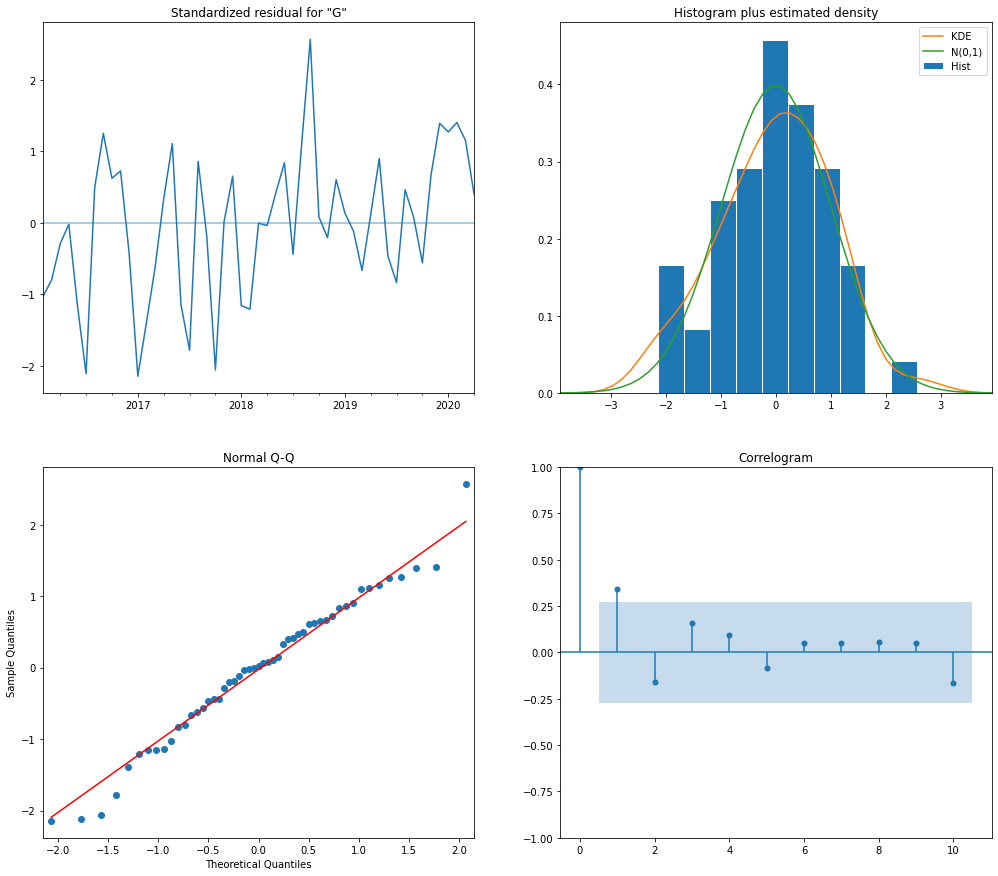

In [24]:
model_fit.plot_diagnostics(figsize=(17,15))
plt.show()

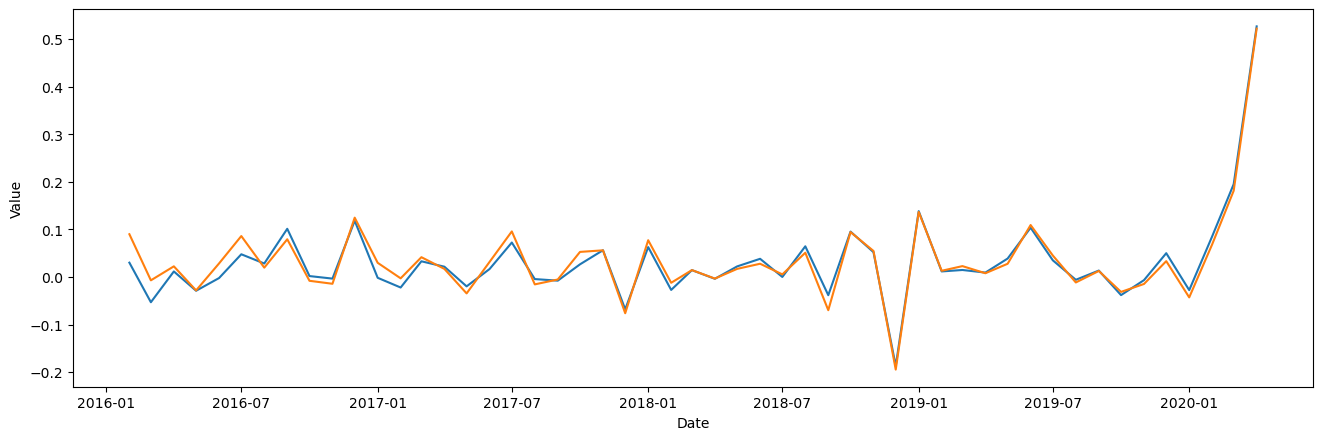

In [25]:
fitted_value = pd.DataFrame({'Original_sales' : train_df['Growth_rate'], 'Fitted_sales' : model_fit.predict()})
plot_df(fitted_value)

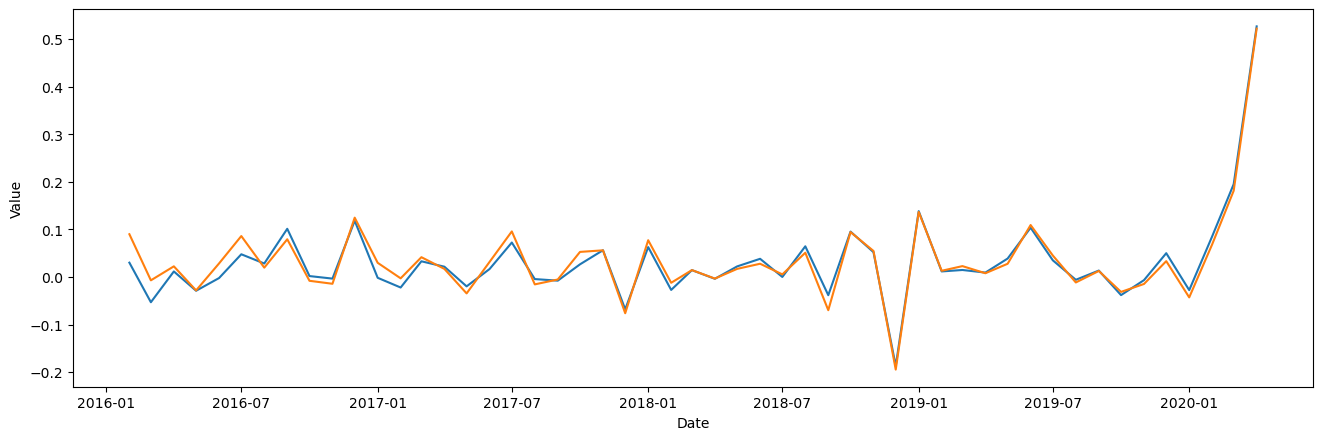

In [26]:
#previous
fitted_value = pd.DataFrame({'Original_sales' : train_df['Growth_rate'], 'Fitted_sales' : model_fit.predict()})
plot_df(fitted_value)

In [225]:
test_df2 = test_df.drop(columns = 'Growth_rate')

In [41]:
result=seasonal_decompose(retailEcommercesales_ts['Growth_rate'],  model='additive')

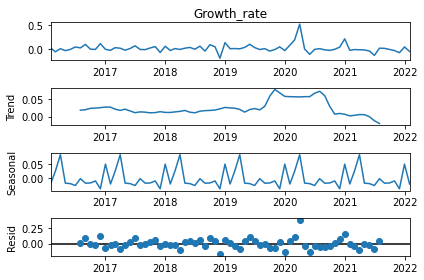

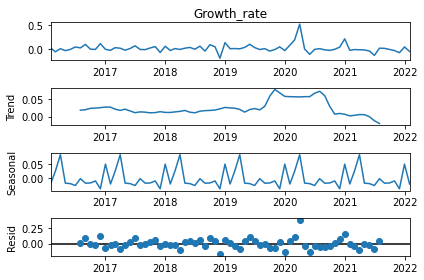

In [42]:
result.plot()

**ARIMA(1,0,1) with stationary data**

In [29]:
def fit_arima_model(train, dependent_var='Growth_rate', ar_order=1, ma_order=1):
    """ fits arma model to the training data set of GDP"""
    model = ARIMA(endog=train[dependent_var],
                  exog=train.loc[:, ~train.columns.isin([dependent_var])],
                  order=(ar_order, 0, ma_order))
    modelfit = model.fit(method='innovations_mle')
    return modelfit

modelfit = fit_arima_model(train = train_df)
print(modelfit.summary())

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Growth_rate   No. Observations:                   51
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 109.545
Date:                Tue, 24 May 2022   AIC                           -151.090
Time:                        10:01:57   BIC                            -85.408
Sample:                    02-01-2016   HQIC                          -125.991
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0228      0.031      0.732      0.464      -0.038       0.084
Uber                        -0.0202      0.037     -0.550      0.582      -0.092       0.

### Rolling Prediction

In [27]:
def rolling_prediction(train, test, dependent_var='Growth_rate'):
    """ Rolling prediction for test set"""
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = fit_arima_model(train)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
        predicted_val = modelfit.forecast(step=1,
                        exog=firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])], dynamic=True)
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train = pd.concat([train, firstrow_test])

        # Drop first row from test set now
        test = test.drop(f"{firstrow_test.index[0]}")

    return pred_data

In [30]:
predict_df = rolling_prediction(train_df, test_df)

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

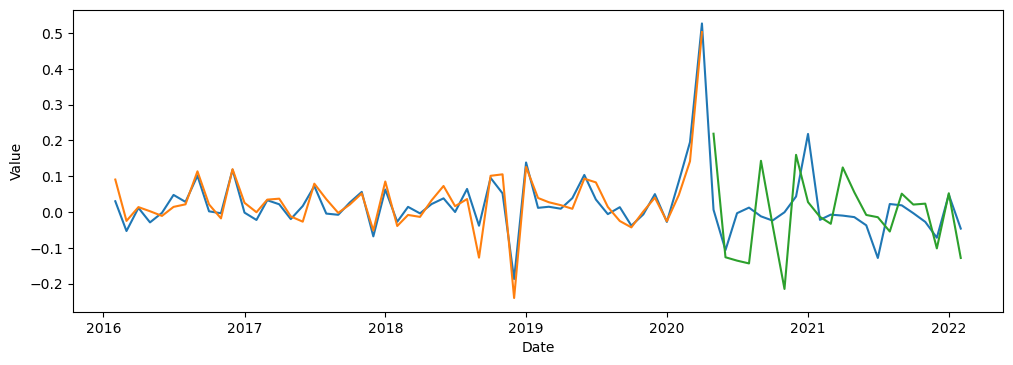

In [31]:
fitted_values = pd.DataFrame({'Growth_rate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': modelfit.predict(),
                              'Predicted Value': predict_df.squeeze()})
plot_df(fitted_values, width=12, height=4)

In [32]:
retailEcommercesales['Date'] = pd.to_datetime(retailEcommercesales['Date'])
retailEcommercesales = retailEcommercesales.set_index(['Date'])
retailEcommercesales[retailEcommercesales.index == train_df.index[-1]]

,Ecommerce_sales
Date,
2020-04-01,3944600


Prediction error: 394971.68298598996


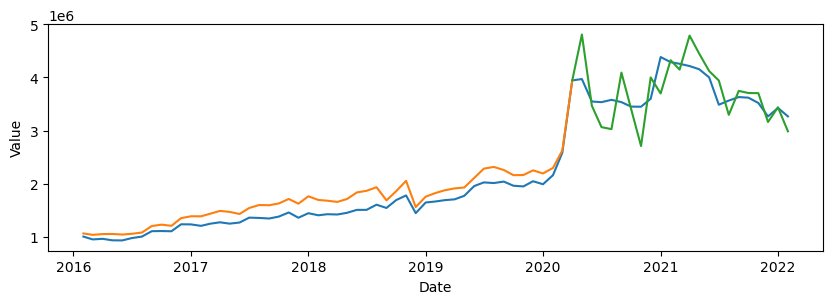

394971.68298598996

In [33]:
# to get fitted original sales

def fitted_and_predicted_sales(modelfit, predict_df, retailEcommercesales, train, test):
    base_sales = retailEcommercesales['Ecommerce_sales'][0]
    fitted_values = modelfit.predict()
    fitted_sales = [0]*(len(fitted_values)+1)
    fitted_sales[0] = base_sales
    for i, value in enumerate(fitted_values):
        fitted_sales[i+1] = fitted_sales[i]*(1 + value)
    fitted_sales_df = pd.DataFrame(fitted_sales[1:])
    fitted_sales_df.index = train.index

    base_sales_test = retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'][0]
    predicted_sales = [0]*(len(predict_df.squeeze()))
    actual_sales = base_sales_test
    for i, value in enumerate(predict_df.squeeze()):
        predicted_sales[i] = actual_sales*(1 + value)
        actual_sales = retailEcommercesales.loc[test.index[i]][0]
    predicted_sales_df = pd.DataFrame(predicted_sales)
    predicted_sales_df.index = predict_df.index
    predicted_sales_df = pd.concat([retailEcommercesales[retailEcommercesales.index == train.index[-1]]['Ecommerce_sales'], predicted_sales_df])

    # prediction error calculation
    org = retailEcommercesales[retailEcommercesales.index >= predicted_sales_df.index[0]]
    error = 0
    for i in range(0, predicted_sales_df.shape[0]):
        error = error + (org['Ecommerce_sales'][i]-predicted_sales_df[0][i])**2
    pred_error = np.sqrt(error/predicted_sales_df.shape[0])
    print(f"Prediction error: {pred_error}")

    # Plot actual and fitted sales
    Actual_sales = retailEcommercesales['Ecommerce_sales'][1:]
    fittedandActual_sales = pd.DataFrame({'Actual sales': Actual_sales,
                                        'Fitted sales': fitted_sales_df.squeeze(),
                                        'Predicted sales': predicted_sales_df.squeeze()
                                       })
    plot_df(fittedandActual_sales, width=10, height=3)
    return pred_error


fitted_and_predicted_sales(modelfit,predict_df, retailEcommercesales, train_df, test_df)

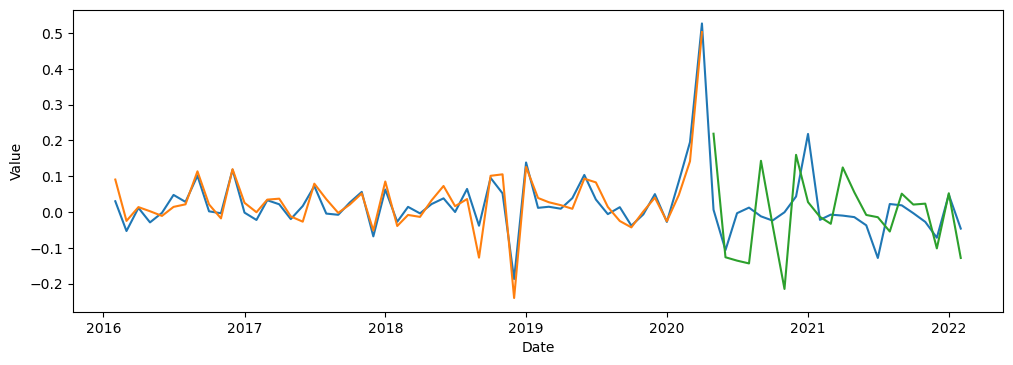

In [34]:
fitted_values = pd.DataFrame({'GDP_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': modelfit.predict(),
                              'Predicted Value': predict_df.squeeze()})
plot_df(fitted_values, width=12, height=4)

In [35]:
# selection of predictors
def predictor_selection(dataframe, year="2005-01-01"):
    temp_data = dataframe.copy()
    q_index = dataframe[(dataframe.index > year)].max()
    for i, qidx in enumerate(q_index):
        if qidx == 100:
            continue
        else:
            temp_data = temp_data.drop(columns = [q_index.index[i]])
    return temp_data

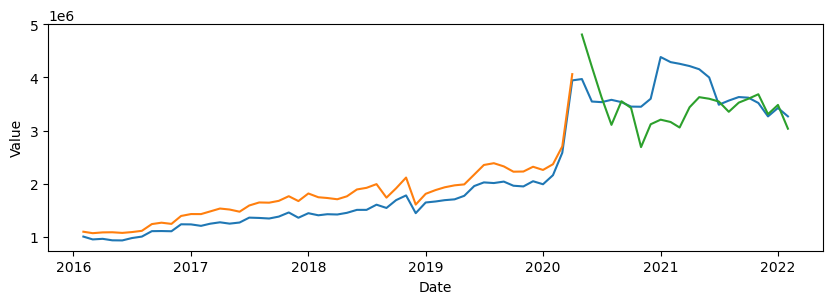

In [42]:
# Plot fitted and predicted GDP

base_sales = retailEcommercesales_ts['Ecommerce_sales'][0]
fitted_values = modelfit.predict()
fitted_sales = [0]*(len(fitted_values)+1)
fitted_sales[0] = base_sales
for i, value in enumerate(fitted_values):
    fitted_sales[i+1] = fitted_sales[i]*(1 + value)
fitted_sales_df = pd.DataFrame(fitted_sales[1:])
fitted_sales_df.index = train_df.index

base_sales = retailEcommercesales_ts[retailEcommercesales_ts.index == train_df.index[-1]]['Ecommerce_sales'][0]
predicted_sales = [0]*(len(predict_df.squeeze())+1)
predicted_sales[0] = base_sales
for i, value in enumerate(predict_df.squeeze()):
    predicted_sales[i+1] = predicted_sales[i]*(1 + value)
predicted_sales_df = pd.DataFrame(predicted_sales[1:])
predicted_sales_df.index = predict_df.index

# Plot actual and fitted GDP
Actual_sa = retailEcommercesales_ts['Ecommerce_sales']
fittedandActual_sales = pd.DataFrame({'Actual sales': Actual_sales,
                                    'Fitted sales': fitted_sales_df.squeeze(),
                                    'Predicted sales': predicted_sales_df.squeeze()
                                   })
plot_df(fittedandActual_sales, width=10, height=3)

## Lasso model

In [ ]:
tempdf = pd.merge(retailEcommercesales_ts[['Growth_rate']], ds_ecommerce_keyword,left_index=True,right_index=True)
tempdf

NameError: name 'ds_ecommerce_keyword' is not defined

In [185]:
y_train = tempdf[['Growth_rate']]
x_train = tempdf.drop(['Growth_rate'],axis=1)

In [190]:
model = Lasso(alpha=0.001,fit_intercept= True, normalize = True, positive= False, selection = 'cyclic')

model.fit(x_train,y_train)

C:\Users\hp\miniconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Lasso(alpha=0.001, normalize=True)

In [191]:
temp_array = model.coef_

In [193]:
temp_list_key = []
for i in range(len(temp_array)):
    if temp_array[i] != 0 :
        temp_list_key.append(i)

temp_df = x_train(temp_list_key)

tempdf_lasso = pd.DataFrame(model.predict(x_train))

[2, 5, 13, 17, 19, 22]


In [212]:
model.coef_

array([ 0.        ,  0.        ,  0.00240302,  0.        , -0.        ,
       -0.00013845,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.04529451,  0.        ,
       -0.        ,  0.        , -0.0008379 ,  0.        , -0.00118373,
        0.        ,  0.        ,  0.04169599, -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ])

In [220]:
tempdf_lasso.index = y_train.index

**ARIMA(1,0,1) on lasso predictors**

In [ ]:
temp_keywordDF = predictor_selection(ecommerce_keyword_ts)
tempkeyword = remove_seasonality(detrend(detrend(normalize(temp_keywordDF))))
tempkeyword2 = tempkeyword.drop(['kijiji'], axis=1)
# Make predictors dataframe in right form
predictor = make_predictors_df(tempkeyword)   #final_category_df
train_df2, test_df2, extra_df2 = ts_train_test_split(retailEcommercesales_ts['Growth_rate'], temp_df, test_size=0.2)
modelfit = fit_arima_model(train_df2)
print(modelfit.summary())

(58, 7)

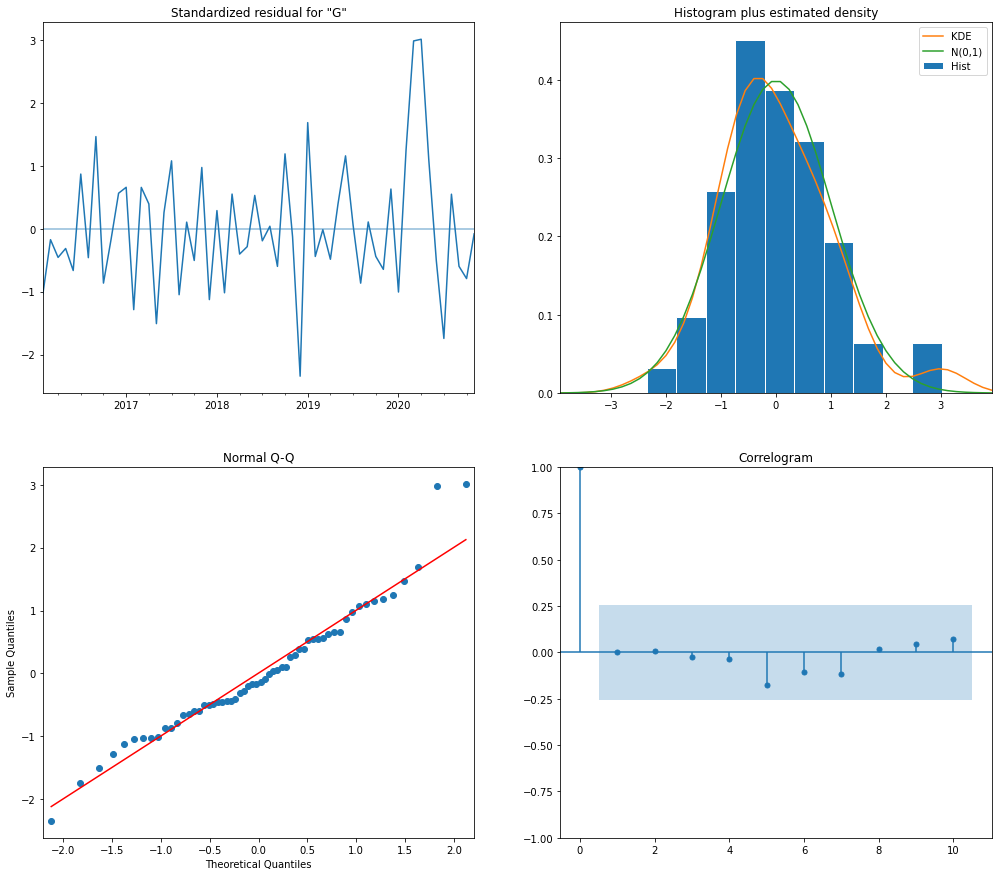

In [ ]:
modelfit.plot_diagnostics(figsize=(17,15))
plt.show()

In [198]:
pred_gdpGrowth = rolling_prediction(train_df2, test_df2)

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

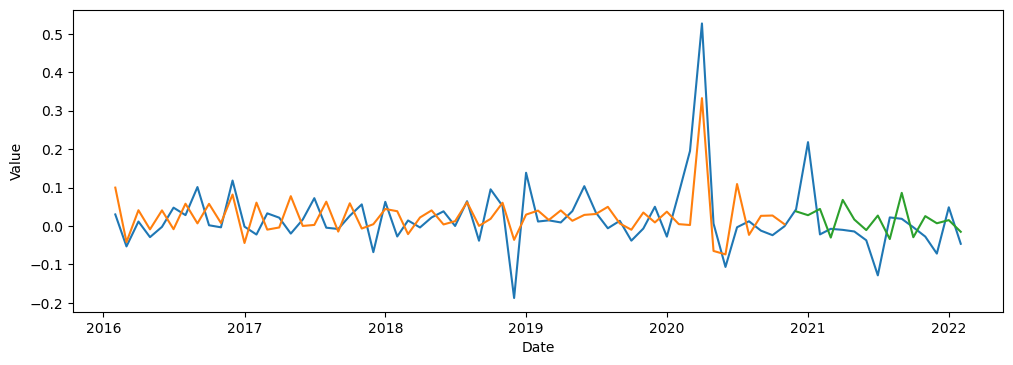

In [199]:
fitted_values = pd.DataFrame({'GDP_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': modelfit.predict(),
                              'Predicted Value': pred_gdpGrowth.squeeze()})
plot_df(fitted_values, width=12, height=4)

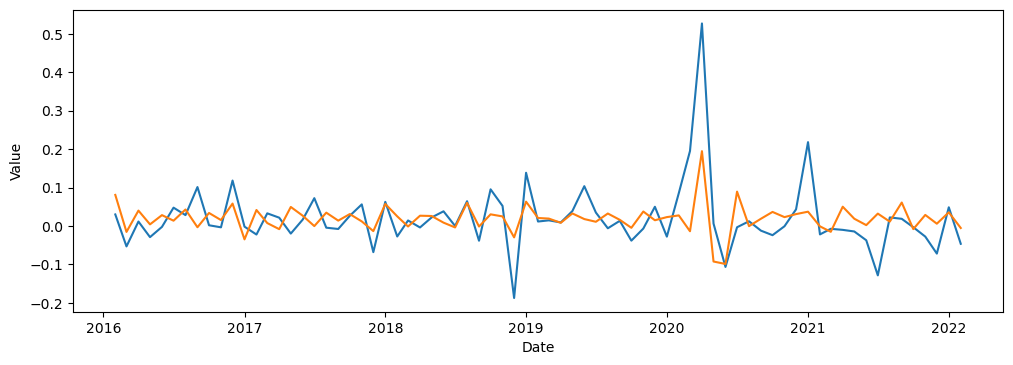

In [223]:
fitted_values = pd.DataFrame({'x_train': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value':model.predict(x_train) })
plot_df(fitted_values, width=12, height=4)

**Uncorrelated predictors ARIMA model**

In [119]:
#categoryts.index = pd.to_datetime(categoryts.index)
cols = list()
data = pd.merge(retailEcommercesales, ecommerce_keyword_ts, left_index=True, right_index=True)

for i in range(0, data.iloc[:,2:].shape[1]):
    
    corr, _ = pearsonr(data['Ecommerce_sales'], data.iloc[:, i+2])
    if abs(corr) > 0.2:
        cols.append(data.columns[i+2])

In [266]:
new_predictors = temp_data[cols]

In [ ]:
print(len(cols))

20


In [127]:
cor_temp_data = data[cols]

In [128]:
cor_temp_data.head()

,DoorDash,SkipTheDishes,Walmart,Costco,ebay,kijiji,Canadian Tire,Best Buy,Shopify,Apple,Old Navy,eventbrite,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,0,17,24,67,62,33,34,24,25,0,7,69,60,55,50,16,12,18,58
2016-02-01,0,0,8,36,52,50,47,18,26,38,23,34,76,58,64,47,11,18,17,50
2016-03-01,0,0,11,25,59,60,24,44,25,25,22,63,72,56,59,52,10,15,13,38
2016-04-01,0,23,17,32,43,69,16,34,27,31,0,26,71,58,57,50,21,13,18,48
2016-05-01,2,0,11,40,54,39,29,54,28,100,67,28,69,59,67,53,54,18,90,40


In [129]:
cor_predictors = make_predictors_df(cor_temp_data)
normalized_corr_keyword = normalize(cor_predictors)
detrend_corr_keyword = (detrend(normalized_corr_keyword))


In [130]:
train_corr_df, test_corr_df, extra_corr_df = ts_train_test_split(retailEcommercesales_ts['Growth_rate'], detrend_corr_keyword, test_size=0.2)
corr_modelfit = fit_arima_model(train_corr_df, dependent_var='Growth_rate', ar_order=1, ma_order=1)

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters foun

In [139]:
predict_corr_df = rolling_prediction(train_corr_df, test_corr_df)

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be

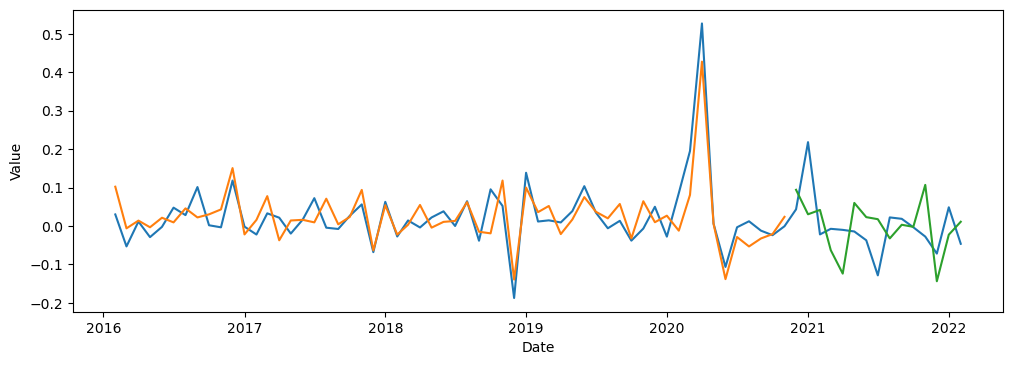

In [141]:
fitted_values = pd.DataFrame({'Growth_rate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': corr_modelfit.predict(),
                              'Predicted Value': predict_corr_df.squeeze()})
plot_df(fitted_values, width=12, height=4)

Prediction error: 49145.2896086548


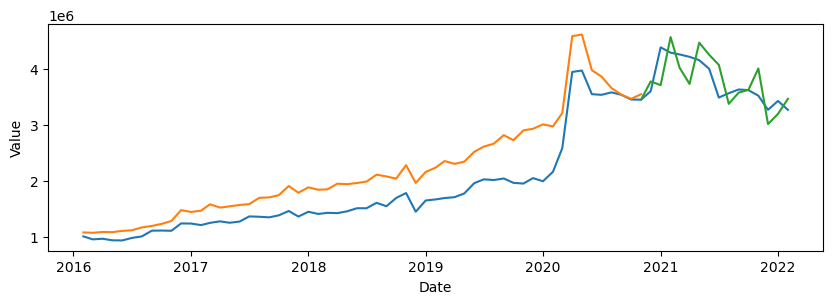

49145.2896086548

In [146]:
fitted_and_predicted_sales(corr_modelfit, predict_corr_df, retailEcommercesales, train_corr_df, test_corr_df)

**Correlation with GDP data**

In [247]:
temp_data = pd.read_csv("gdp_category_ts.csv", index_col = 0)
temp_data.head(2)

,569,23,47,815,170,249,71,276,634,250,...,53,342,1159,1214,670,12,566,672,673,49
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,74,90,91,94,89,86,76,57,60,90,...,100,90,95,77,68,100,88,74,91,88
2004-02-01,70,85,89,93,88,87,72,58,52,98,...,96,100,95,91,77,99,96,79,82,100


In [255]:
temp_data.rename(index={'date': 'Date'}, inplace=True)

In [258]:
temp_data.index = pd.to_datetime(temp_data.index) 

**DFM model**

In [45]:
def apply_dfm(predictor, num_factors=20, order_factors=1):
    model = sm.tsa.DynamicFactor(endog=predictor, k_factors=num_factors, factor_order=order_factors)
    res = model.fit()
    final = model.fit(res.params)
    factors = np.transpose(pd.DataFrame(final.factors.filtered))
    factors.index = predictor.index
    return factors

dfm_df = apply_dfm(detrend_ecommerce_keyword)

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [158]:
dfm_df.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Date,,,,,,,,,,,,,,,,,,,,
2004-02-01,0.001578,-0.018720,0.048157,0.072203,-0.051338,-0.087558,-0.155940,0.009138,-0.092597,0.075979,0.035961,-0.031052,-0.018125,-0.055641,0.019947,-0.090907,-0.084958,0.161790,-0.041811,0.043625
2004-03-01,0.044400,0.091951,-0.091031,-0.140215,0.182448,0.206149,0.082431,0.164499,-0.058080,0.005173,0.047386,0.110620,-0.067400,-0.029133,-0.119074,0.092015,-0.117005,-0.005301,-0.049064,-0.024346


**DFM factor selection Loop**

In [46]:
train_dfm_df, test_dfm_df, extra_dfm_df = ts_train_test_split(retailEcommercesales_ts['Growth_rate'], dfm_df.iloc[:,0:15], test_size=0.2)
dfm_modelfit = fit_arima_model(train_dfm_df, dependent_var='Growth_rate', ar_order=1, ma_order=1)


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [47]:
predict_dfm_df = rolling_prediction(train_dfm_df, test_dfm_df)

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

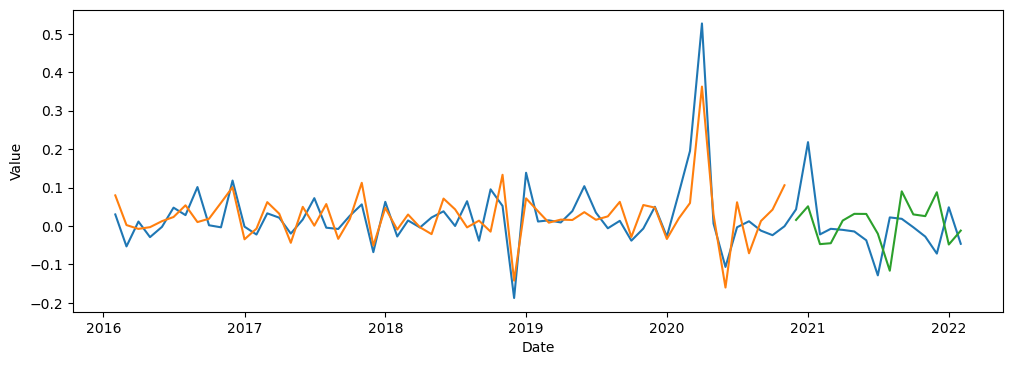

In [48]:
fitted_values = pd.DataFrame({'Growth_rate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': dfm_modelfit.predict(),
                              'Predicted Value': predict_dfm_df.squeeze()})
plot_df(fitted_values, width=12, height=4)

Prediction error: 306678.63830684667


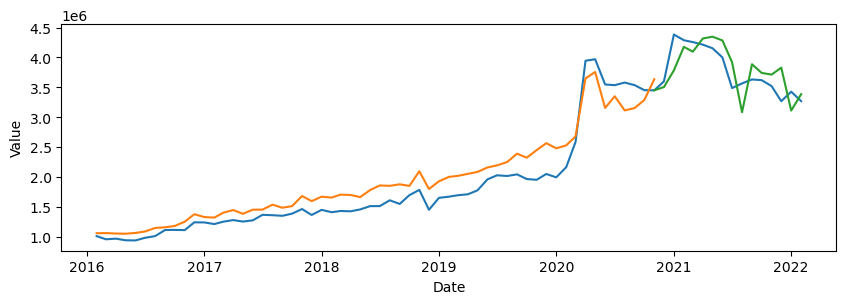

306678.63830684667

In [53]:
fitted_and_predicted_sales(dfm_modelfit,predict_dfm_df, retailEcommercesales, train_dfm_df, test_dfm_df)

### XGBoost

In [62]:
# predictors 
xgboostcat = detrend(normalize(ecommerce_keyword_ts))

# response
xgboost_response = retailEcommercesales_ts[['Growth_rate']].iloc[1:,:]


In [60]:
ecommerce_keyword_ts.head(2)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,59,0,...,0,0,53,36,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,49,46,47,0,0,0,0,0


In [59]:
retailEcommercesales_ts[['Growth_rate']].iloc[1:,:]

,Growth_rate
Date,
2016-02-01,0.030098
2016-03-01,-0.053073
2016-04-01,0.011638
2016-05-01,-0.028947
2016-06-01,-0.002234
...,...
2021-10-01,-0.003243
2021-11-01,-0.027532
2021-12-01,-0.071779


In [74]:
lag1 = retailEcommercesales_ts[['Growth_rate']].iloc[0:retailEcommercesales_ts.shape[0]-1,:]
lag1.index = xgboost_response.index
lag1 = lag1.rename(columns={'Growth_rate': 'lag1'})
xgboost_predictors = make_predictors_df(lag1, ecommerce_keyword_ts)

In [75]:
xgboost_response.shape

(72, 1)

In [66]:
xgboost_predictors.shape

(72, 31)

In [76]:
train_xgboost, test_xgboost, _ = ts_train_test_split(xgboost_response, xgboost_predictors, test_size=0.2)
train_xgboost.shape

(57, 32)

In [91]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [107]:
trainX, trainy = train_xgboost.iloc[:, 1:], train_xgboost['Growth_rate']
testX, testy = test_xgboost.iloc[:, 1:], test_xgboost.iloc[:, -0]

In [102]:
train_xgboost.head(2)

,Growth_rate,lag1,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2016-03-01,-0.053073,0.030098,38,0,0,11,25,0,33,0,...,0,24,72,56,59,52,10,15,13,38
2016-04-01,0.011638,-0.053073,46,0,23,17,32,0,19,0,...,40,37,71,58,57,50,21,13,18,48


In [93]:
xgboostmodel = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
xgboostmodel.fit(trainX, trainy)
# make a one-step prediction
#yhat = model.predict([testX])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [133]:
fitted_growthRate_xgboost = xgboostmodel.predict(trainX)
fitted_growthRate_xgboost.squeeze()
fitted_growthRate_xgboost = pd.DataFrame(fitted_growthRate_xgboost, columns={'Fitted Ecommerce_GrowthRate'})
fitted_growthRate_xgboost.index = train_xgboost.index

In [99]:
trainy.head(2)

Date
2016-03-01   -0.053073
2016-04-01    0.011638
Name: Growth_rate, dtype: float64

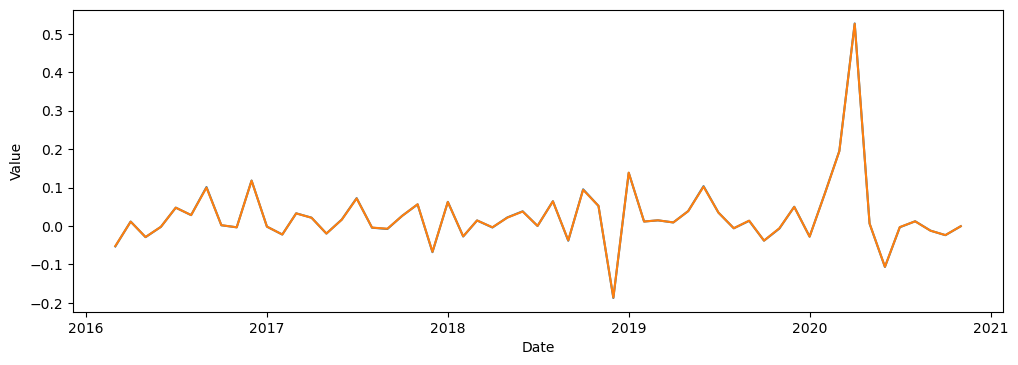

In [109]:
fitted_values_xgboost = pd.DataFrame({'GrowthRate': train_xgboost['Growth_rate'],
                              'Fitted Value': fitted_growthRate_xgboost.squeeze()})
plot_df(fitted_values_xgboost, width=12, height=4)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

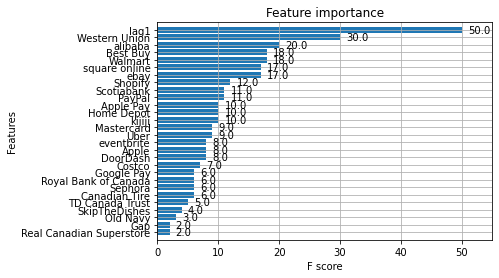

In [116]:
plot_importance(xgboostmodel, height=0.8)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

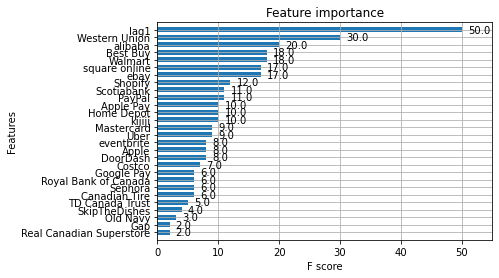

In [124]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

def xgboost_modelfit(train_xgboost, response_var='Growth_rate'):
    """ fits xgboost model to the passed data"""
    X_xgboost, Y_xgboost = train_xgboost.loc[:, ~train_xgboost.columns.isin([response_var])], train_xgboost[[response_var]]
    xgboostmodel = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    xgboostmodel.fit(X_xgboost, Y_xgboost)
    return xgboostmodel

plot_importance(xgboostmodel, height=0.7)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

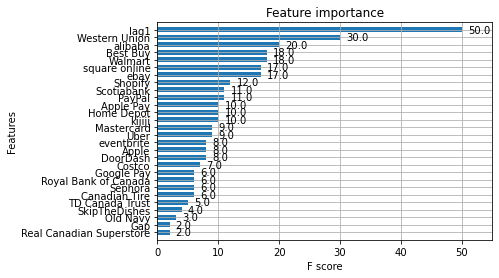

In [121]:
xgboost_modelfit(train_xgboost)

In [122]:
def rolling_prediction_xgboost(train_xgboost, test_xgboost, dependent_var='Growth_rate'):
    """ Rolling prediction for test set"""
    train_samples = train_xgboost.shape[0]
    test_samples = test_xgboost.shape[0]
    pred_data = pd.DataFrame(columns=None)
    test_data = test_xgboost.copy()
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = xgboost_modelfit(train_xgboost)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test_xgboost.iloc[0, :])))
        predicted_val = modelfit.predict(firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])])
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train_xgboost = pd.concat([train_xgboost, firstrow_test])

        # Drop first row from test set now
        test_xgboost = test_xgboost.drop(f"{firstrow_test.index[0]}")

    pred_data.index = test_data.index
    return pred_data

In [125]:
xgboost_pred_salesgrowth = rolling_prediction_xgboost(train_xgboost, test_xgboost, dependent_var='Growth_rate')


In [135]:
xgboost_pred_salesgrowth.index


DatetimeIndex(['2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01',
               '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01'],
              dtype='datetime64[ns]', name='Date', freq=None)

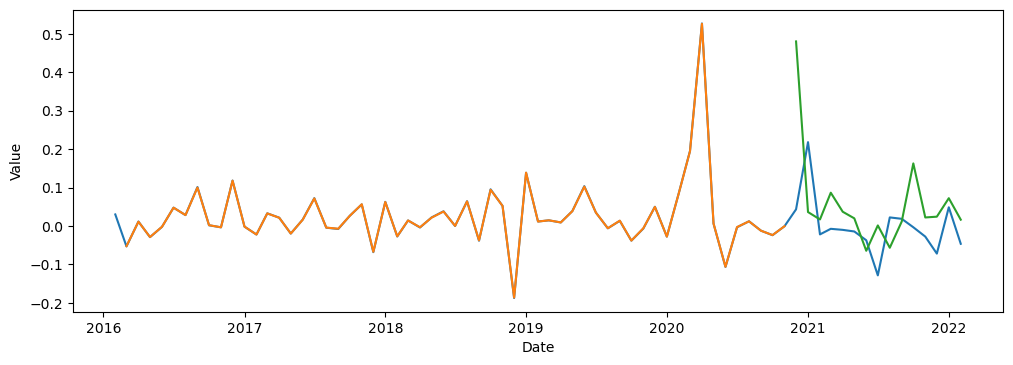

In [136]:
fitted_values_xgboost = pd.DataFrame({'Ecommerce_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                                'Fitted Value': fitted_growthRate_xgboost.squeeze(),
                                'Predicted Value': xgboost_pred_salesgrowth.squeeze()})
plot_df(fitted_values_xgboost, width=12, height=4)